In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
#sns.set_style("darkgrid")
sns.set_style("white")


import holidays
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
tx_path = '/data/projects/texas-power-outages/data/interim/'
fig_path = '/data/projects/texas-power-outages/data/figures/'
out_path = '/data/projects/texas-power-outages/data/output/'
in_path = '/data/projects/texas-power-outages/data/input/'

fig_path_raw = fig_path+'raw_data/'

In [3]:
# load temperature population indicator
tpxr = xr.open_mfdataset(tx_path + 'temperatures/temppop/temppop_????C.nc').__xarray_dataarray_variable__
tpxr.name= 'tp'
tp = tpxr.to_dataframe().tz_localize('UTC').tz_convert('Etc/GMT+6')
tpd = tp.resample('D').mean()

In [4]:
# load CFs
cfh = pd.read_csv(tx_path + 'windpower/cfTXh.csv',index_col=0,parse_dates=True).tz_localize('UTC').tz_convert('Etc/GMT+6')
cfd = cfh.resample('D').mean()

In [5]:
# load load with Feb2021
ldh = pd.read_csv(tx_path + 'load/load_2002-2021h_Feb.csv',index_col=0,header=None,parse_dates=True
                 ).tz_convert('Etc/GMT+6')
ldh.index.name = 'time'
ldh.columns = ['ld']
# one value is missing - interpolate
ldh = ldh.interpolate()

In [6]:
# start at 2004
load = ldh['2004':]

In [7]:
# load load forecast
fc = pd.read_csv(in_path + 'Load/load_forecast_ercot2.csv',parse_dates=True)
ampm = {'a.m.':0, 'p.m.':12}
fc.index = [pd.to_datetime(d[0]) + np.timedelta64(int(d[1])+ampm.get(d[2]),'h') for d in fc['Timestamp (Hour Ending)'].str.replace('12 a.m.','0 a.m.').str.replace('12 p.m.','12 a.m.').str.split(' ')]
fc = fc.tz_localize('Etc/GMT+6')

In [8]:
# add load forecast to load data
loadfc = pd.concat([load[:'2021-01'].ld,fc['2021-02']['Demand Forecast (MWh)']],axis=0)
# cut temperature data
tpfc = tp[:loadfc.index[-1]]

### load outage data

In [9]:
reduction = pd.read_csv(tx_path+'outages/outages_reduction.csv',index_col='time',parse_dates=['time']).tz_localize(None).tz_localize('Etc/GMT+6')
# get wind power
wp = pd.read_csv(tx_path + 'windpower/wpTXh.csv',parse_dates=True,index_col=0).tz_localize('UTC').tz_convert('Etc/GMT+6').wp

In [10]:
out_wind = pd.concat([pd.Series(0,index=loadfc['2021-02':'2021-02-09 23'].index), reduction.WIND])
out_thermal = pd.concat([pd.Series(0,index=loadfc['2021-02':'2021-02-09 23'].index),reduction[['NG','COAL']].sum(axis=1)])
remain = (62 - out_thermal/1000 + wp/10**6*(33-out_wind/1000)/33).dropna()

## make model

In [11]:
def print_stat(a,b):
    cor = np.corrcoef(a, b)[0,1]
    rmse = (((a/1000-b/1000)**2).sum()/len(a))**0.5
    r2 = r2_score(a, b)
    print('cor',round(cor,2))
    print('rmse',round(rmse,2))
    print('R2',round(r2,2))
def h_of_y(d):
    day = d.timetuple().tm_yday
    return(d.hour + (day-1)*24)
def makex(time,temp,trend_start,ref_time=0):
    holidaysTX = pd.to_datetime(np.array(list(holidays.CountryHoliday('US', prov=None,state='TX',years=range(1950,2022)).keys()))).tz_localize('Etc/GMT+6')
    
    holiday = np.array([x in holidaysTX.date for x in time.date]).astype(int).reshape((len(time),1))
    hours = pd.get_dummies(time.hour.values).values
    weekdays = pd.get_dummies(time.dayofweek.values).values
    
    hy = time.map(h_of_y)
    ampl1 = np.cos(2*np.pi*hy/8760).values.reshape((len(time),1))
    ampl2 = np.sin(2*np.pi*hy/8760).values.reshape((len(time),1))
    
    if ref_time:
        trend = [(pd.to_datetime(ref_time) - pd.to_datetime(trend_start).tz_localize(time.tz))/np.timedelta64(1,'h')]*len(time)
    else:
        trend = (time - pd.to_datetime(trend_start).tz_localize(time.tz))/np.timedelta64(1,'h')
    trend = np.reshape(trend,(len(trend),1))
    x = np.concatenate((hours,weekdays,holiday,ampl1,ampl2,trend,trend*temp.values,temp,temp**2,temp**4),axis=1)
    return(x)
def est_load(loady,tempy,trend_start='2004-01-01',ref_time=0):
    y = loady
    x = makex(y.index,tempy,trend_start,ref_time)
    model = LinearRegression().fit(x, y.ld.values)
    load_est = pd.Series(model.predict(x),index=y.index)
    ldtp = pd.concat([y,load_est,tempy],axis=1)
    ldtp.columns = ['load','load_est','temp']
    return(ldtp)
def est_load70(loady,tempy,modelyear,trend_start='2004-01-01',ref_time=0):
    # estimate model
    ymy = loady[modelyear]
    xmy = makex(ymy.index,tempy[modelyear],trend_start,ref_time=0)
    modelmy = LinearRegression().fit(xmy, ymy.ld.values)
    # estimate load
    x = makex(tempy.index,tempy,trend_start,ref_time=0)
    load_est = pd.Series(modelmy.predict(x),index=tempy.index)
    ldtp = pd.concat([load_est,tempy],axis=1)
    ldtp.columns = ['load_est','temp']
    return(ldtp)
def est_load70_years(loady,tempy,modelyear1,modelyear2,thresh_temp,use_low=True,trend_start='2004-01-01',ref_time=0):
    '''
    loady, tempy: time series of load and temperature
    modelyear1,2: timespan to use for modelling
    thresh_temp: temperature threshold where to make break and cut off load function
    use_low: use low temperatures below thresh_temp for modelling
    trend_start: date for starting timetrend
    ref_time: if set to time use constant time trend for that time for prediction, else use normal time trend
    '''
    tempy_nocold = tempy[tempy.tp>=thresh_temp]
    tempy_coldcut = tempy.copy(deep=True)
    tempy_coldcut[tempy_coldcut<thresh_temp] = thresh_temp
    loady_nocold = loady[tempy.tp>=thresh_temp]
    # estimate model
    if use_low:
        ymy = loady[modelyear1:modelyear2]
        xmy = makex(ymy.index,tempy[modelyear1:modelyear2],trend_start,ref_time=0)
    else:
        ymy = loady_nocold[modelyear1:modelyear2]
        xmy = makex(tempy_nocold[modelyear1:modelyear2].index,tempy_nocold[modelyear1:modelyear2],trend_start,ref_time=0)
    modelmy = LinearRegression().fit(xmy, ymy.values)
    # estimate load
    x = makex(tempy_coldcut.index,tempy_coldcut,trend_start,ref_time)
    load_est = pd.Series(modelmy.predict(x),index=tempy_coldcut.index)
    ldtp = pd.concat([load_est,tempy],axis=1)
    ldtp.columns = ['load_est','temp']
    return(ldtp)

### model load only for winter

In [17]:
load_winter = load[(load.index.month==1)|(load.index.month==2)|(load.index.month==12)]
tp_winter = tp[(tp.index.month==1)|(tp.index.month==2)|(tp.index.month==12)]
loadfc_winter = loadfc[(loadfc.index.month==1)|(loadfc.index.month==2)|(loadfc.index.month==12)]
tpfc_winter = tpfc[(tpfc.index.month==1)|(tpfc.index.month==2)|(tpfc.index.month==12)]

# predict with 2012-2020

In [101]:
# estimate load 70 years
ldtp70_winter_1220_tt8 = est_load70_years(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01',load.index[-1]) # changed model year to 2012-2020

In [103]:
ldtp70_winter_1220_tt8.to_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv')

In [39]:
ldtp70_winter_1220_tt8 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

In [104]:
print('2020 est. with 2012-2020')
print_stat(ldtp70_winter_1220_tt8.load_est['2020'],load_winter.ld['2020'])
print('\n2021-01 est. with 2012-2020')
print_stat(ldtp70_winter_1220_tt8.load_est['2021-01'],load.ld['2021-01'])

2020 est. with 2012-2020
cor 0.94
rmse 1.68
R2 0.85

2021-01 est. with 2012-2020
cor 0.96
rmse 1.32
R2 0.92


In [113]:
est_load70_detrend = ldtp70_winter_1220_tt8

In [115]:
ldtp70_winter_1220 = ldtp70_winter_1220_tt8

In [ ]:
print('2020 est. with 2012-2020')
print_stat(est_load70_detrend.load_est['2020'],load_winter.ld['2020'])
print('\n2021-01 est. with 2012-2020')
print_stat(est_load70_detrend.load_est['2021-01'],load.ld['2021-01'])

In [ ]:
#plt.scatter(est_load70_detrend.temp['2021-01'],(est_load70_detrend.load_est['2021-01']-load.ld['2021-01']).dropna()/1000)
plt.scatter(tp['2021-01'],(est_load70_detrend.load_est['2021-01']-load.ld['2021-01']).dropna()/1000)
plt.title('error LR model 2012-2021 detrend 2021')

# predict single years with 2012-2020

In [12]:
def est_load_model(loady,tempy,modelyear1,modelyear2,thresh_temp,use_low=True,trend_start='2004-01-01'):
    tempy_nocold = tempy[tempy.tp>=thresh_temp]
    tempy_coldcut = tempy.copy(deep=True)
    tempy_coldcut[tempy_coldcut<thresh_temp] = thresh_temp
    loady_nocold = loady[tempy.tp>=thresh_temp]
    # estimate model
    if use_low:
        ymy = loady[modelyear1:modelyear2]
        xmy = makex(ymy.index,tempy[modelyear1:modelyear2],trend_start)
    else:
        ymy = loady_nocold[modelyear1:modelyear2]
        xmy = makex(ymy.index,tempy_nocold[modelyear1:modelyear2],trend_start)
    modelmy = LinearRegression().fit(xmy, ymy.values)
    return(modelmy)
def est_load_with_model(tempy,modelmy,thresh_temp,trend_start='2004-01-01',ref_time=0):
    tempy_coldcut = tempy.copy(deep=True)
    tempy_coldcut[tempy_coldcut<thresh_temp] = thresh_temp
    # estimate load
    x = makex(tempy.index,tempy_coldcut,trend_start,ref_time)
    load_est = pd.Series(modelmy.predict(x),index=tempy_coldcut.index)
    return(load_est)

In [13]:
def est_load1_year(loady,tempy,modelyear1,modelyear2,thresh_temp,use_low=True,trend_start='2004-01-01',sim_year=2021,ref_time=0):
    tempy_nocold = tempy[tempy.tp>=thresh_temp]
    tempy_coldcut = tempy.copy(deep=True)
    tempy_coldcut[tempy_coldcut<thresh_temp] = thresh_temp
    loady_nocold = loady[tempy.tp>=thresh_temp]
    # estimate model
    if use_low:
        ymy = pd.concat([loady[modelyear1:str(sim_year-1)],loady[str(sim_year):modelyear2]])
        xmy = pd.concat([tempy[modelyear1:str(sim_year-1)],tempy[str(sim_year):modelyear2]])
        xmy = makex(ymy.index,xmy,trend_start)
    else:
        ymy = pd.concat([loady_nocold[modelyear1:str(sim_year-1)],loady_nocold[str(sim_year):modelyear2]])
        xmy = pd.concat([tempy_nocold[modelyear1:str(sim_year-1)],tempy_nocold[str(sim_year):modelyear2]])
        xmy = makex(ymy.index,xmy,trend_start)
    modelmy = LinearRegression().fit(xmy, ymy.values)
    # estimate load
    x = makex(tempy_coldcut[str(sim_year)].index,tempy_coldcut[str(sim_year)],trend_start,ref_time)
    load_est = pd.Series(modelmy.predict(x),index=tempy[str(sim_year)].index)
    return(load_est)

In [14]:
def print_stat_latex(a,b,year):
    cor = np.corrcoef(a, b)[0,1]
    rmse = (((a/1000-b/1000)**2).sum()/len(a))**0.5
    r2 = r2_score(a, b)
    print(year,'&',round(cor,2),'&',round(rmse,2),'&',round(r2,2),'\\')

### estimate load for each year with entire model

In [18]:
# estimate load for each year
model = est_load_model(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01')
ldtp10_winter_1221 = est_load_with_model(tpfc_winter['2012':],model,-8,'2004-01-01',0)

In [23]:
load_est10 = pd.concat([load,ldtp10_winter_1221],axis=1).dropna()
load_est10.columns = ['load','load_est']
load_est10.to_csv(tx_path + 'load/load_est10_LR24temptrend_Hook-8.csv')

#### plot in temperature bins

In [30]:
temp_bins = pd.cut(tpfc_winter.tp,pd.IntervalIndex.from_tuples([(-15,-13),(-13,-11),(-11,-9),(-9,-7),(-7,-5),(-5,-3),(-3,-1),
                                                    (-1,1),(1,3),(3,5),(5,7),(7,9),(9,11),(11,13),(13,15),(15,17),(17,19),
                                                    (19,21),(21,23),(23,25),(25,27),(27,29),(29,31),(31,33)]))

In [ ]:
plt.figure(figsize=(15,6))

df = pd.DataFrame({'error':(load_est10.load_est - loadfc_winter)/1000,
                   'temp_bins':temp_bins})

ax = sns.boxplot(x = 'temp_bins', y = 'error',
            data=df)
plt.xticks(rotation=45)


medians = df.groupby(['temp_bins'])['error'].median().values
#nobs = df['temp_bins'].value_counts().values
#nobs = [str(x) for x in nobs.tolist()]
#nobs = [i for i in nobs]
nobs = df.groupby('temp_bins').count().values[:,0]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black',
            weight='semibold')

In [ ]:
plt.scatter(tpfc_winter.tp['2012':],loadfc_winter['2012':])

In [31]:
temp_bins2 = pd.cut(tpfc_winter.tp,pd.IntervalIndex.from_tuples([(-15,-7),(-7,-5),(-5,-3),(-3,-1),
                                                    (-1,1),(1,3),(3,5),(5,7),(7,9),(9,11),(11,13),(13,15),(15,17),(17,19),
                                                    (19,21),(21,23),(23,25),(25,27),(27,31)]))

In [36]:
load_est10 = pd.read_csv(tx_path + 'load/load_est10_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True)

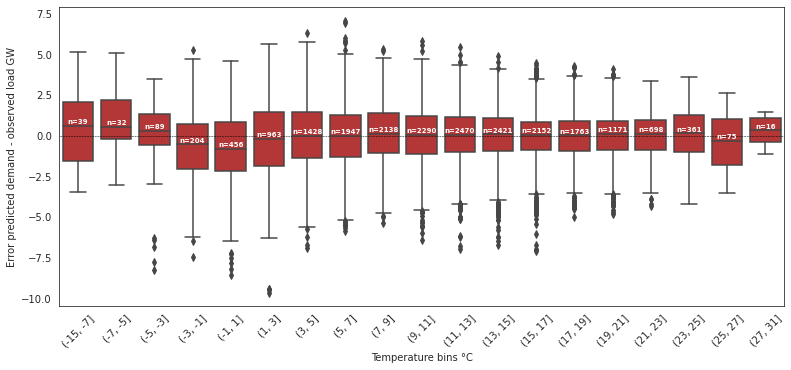

In [45]:
plt.figure(figsize=(13,5.5))

df = pd.DataFrame({'error':(load_est10.load_est - loadfc_winter)/1000,
                   'temp_bins':temp_bins2})

ax = sns.boxplot(x = 'temp_bins', y = 'error',data=df,color=COLORS[0])
ax.axhline(0,-0.5,18.5,color='black',lw=0.5,ls='--')
plt.xticks(rotation=45)


medians = df.groupby(['temp_bins'])['error'].median().values
nobs = df.groupby('temp_bins').count().values[:,0]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.1,
            'n='+str(nobs[tick]),
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')
plt.xlabel('Temperature bins °C')
plt.ylabel('Error predicted demand - observed load GW')
plt.savefig(fig_path + 'error_tempbin_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

In [49]:
df.to_csv(fig_path_raw + 'FigA6.csv')

### estimate load for each year but use model for years except test year

#### 2012-2020

In [94]:
# estimate load for each year
for year in range(2012,2021):
    ldtp1_winter_1221 = est_load1_year(loadfc_winter,tpfc_winter,'2012','2021',-8,False,'2004-01-01',year) # changed model year to 2012-2021
    if 'ldtp9_winter_1221' in globals():
        ldtp9_winter_1221 = pd.concat([ldtp9_winter_1221,ldtp1_winter_1221],axis=0)
    else:
        ldtp9_winter_1221 = ldtp1_winter_1221

In [95]:
load_est9 = pd.concat([loadfc_winter,ldtp9_winter_1221],axis=1)
load_est9.columns = ['load','load_est']
load_est9.to_csv(tx_path + 'load/load_est9_LR24temptrend2021_Hook-8.csv')

(-10.0, 8.0)

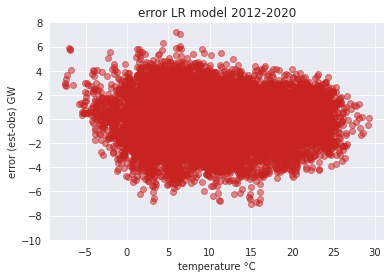

In [99]:
plt.scatter(tpfc_winter.tp['2012':'2020'],(ldtp9_winter_1221-loadfc_winter)['2012':'2020'].dropna()/1000,alpha=0.5,label='2012-2020')
plt.title('error LR model 2012-2020')
plt.xlabel('temperature °C')
plt.ylabel('error (est-obs) GW')
plt.ylim((-10,8))

Text(0.5, 1.0, 'error est-obs')

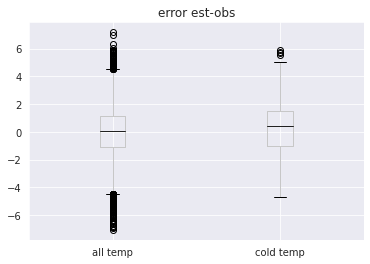

In [102]:
pd.DataFrame({'all temp':(ldtp9_winter_1221-loadfc_winter).dropna()/1000,
              'cold temp':(ldtp9_winter_1221-loadfc_winter).dropna()[tpfc_winter.tp<0]/1000}).boxplot()
plt.title('error est-obs')

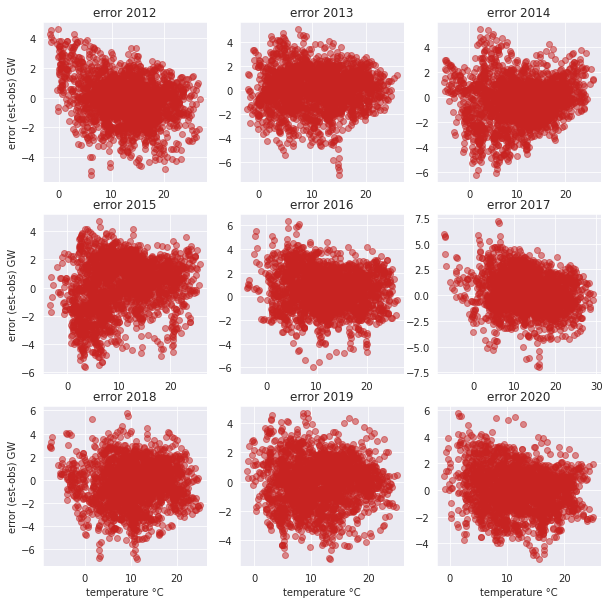

In [101]:
fig,axes = plt.subplots(3,3,figsize=(10,10))
axs = axes.flat
for i in range(9):
    ax = axs[i]
    year = str(2012 + i)
    ax.scatter(tp_winter.tp[year],(ldtp9_winter_1221[year]-loadfc_winter[year]).dropna()/1000,alpha=0.5)
    ax.set_title('error '+ year)
    if i > 5:
        ax.set_xlabel('temperature °C')
    else:
        ax.set_xlabel('')
    if (i % 3) == 0:
        ax.set_ylabel('error (est-obs) GW')
    else:
        ax.set_ylabel('')
#plt.savefig(fig_path + '/fit_load_model_2012-2020_LR24temptrend2012_Hook-8.pdf',dpi=300)

#### 2004-2020

In [55]:
# estimate load for each year
for year in range(2004,2022):
    ldtp1_winter_1220 = est_load1_year(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01',year) # changed model year to 2012-2021
    if 'ldtp17_winter_1220' in globals():
        ldtp17_winter_1220 = pd.concat([ldtp17_winter_1220,ldtp1_winter_1220],axis=0)
    else:
        ldtp17_winter_1220 = ldtp1_winter_1220

In [56]:
load_est17_crossvalidation = pd.concat([loadfc_winter,ldtp17_winter_1220],axis=1)
load_est17_crossvalidation.columns = ['load','load_est']
load_est17_crossvalidation.to_csv(tx_path + 'load/load_est17_crossvalidation_LR24temptrend_Hook-8.csv')

In [59]:
print('Year & Correlation & RMSE & R2\\ \hline')
for year in range(2004,2021):
    print_stat_latex(load_est17_crossvalidation[str(year)].load_est,load_est17_crossvalidation[str(year)].load,year)
print_stat_latex(load_est17_crossvalidation['2021-01'].load_est,load_est17_crossvalidation['2021-01'].load,'2021-01')

Year & Correlation & RMSE & R2\ \hline
2004 & 0.96 & 1.41 & 0.9 \
2005 & 0.95 & 1.6 & 0.87 \
2006 & 0.94 & 1.52 & 0.86 \
2007 & 0.92 & 2.43 & 0.74 \
2008 & 0.93 & 2.24 & 0.77 \
2009 & 0.94 & 1.66 & 0.88 \
2010 & 0.96 & 1.66 & 0.9 \
2011 & 0.97 & 1.59 & 0.94 \
2012 & 0.95 & 1.46 & 0.9 \
2013 & 0.96 & 1.65 & 0.9 \
2014 & 0.96 & 1.74 & 0.92 \
2015 & 0.95 & 1.89 & 0.87 \
2016 & 0.94 & 1.71 & 0.87 \
2017 & 0.95 & 1.79 & 0.89 \
2018 & 0.96 & 1.88 & 0.9 \
2019 & 0.94 & 1.62 & 0.87 \
2020 & 0.94 & 1.58 & 0.87 \
2021-01 & 0.96 & 1.31 & 0.92 \


## plot model range

In [18]:
model = est_load_model(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01')

In [19]:
coef = model.coef_
inte = model.intercept_

#### plot with "hose"

find minimum and maximum within period

In [20]:
i = tp_winter.tp['2012':'2020'].index
xs = makex(i,pd.DataFrame({'tp':[-8]},index=i),'2004-01-01',ref_time=0)
ys = ((xs*coef).sum(axis=1)+inte)/1000

i2021 = tp_winter.tp['2021'].index
xs2021 = makex(i2021,pd.DataFrame({'tp':[-8]},index=i2021),'2004-01-01',ref_time=0)
ys2021 = ((xs2021*coef).sum(axis=1)+inte)/1000

In [21]:
max_time = tp_winter['2012':'2020'].index[ys==ys.max()]
min_time = tp_winter['2012':'2020'].index[ys==ys.min()]

max_time2021 = tp_winter['2021'].index[ys2021==ys2021.max()]
min_time2021 = tp_winter['2021'].index[ys2021==ys2021.min()]

In [22]:
t = np.arange(-15,40)
t2 = t.copy()
t2[t2<-8] = -8

tdf_min = pd.DataFrame({'tp':t},index=np.repeat(min_time,len(t)))
tdf_max = pd.DataFrame({'tp':t},index=np.repeat(max_time,len(t)))
t2df_min = pd.DataFrame({'tp':t2},index=np.repeat(min_time,len(t2)))
t2df_max = pd.DataFrame({'tp':t2},index=np.repeat(max_time,len(t2)))

tdf_min2021 = pd.DataFrame({'tp':t},index=np.repeat(min_time2021,len(t)))
tdf_max2021 = pd.DataFrame({'tp':t},index=np.repeat(max_time2021,len(t)))
t2df_min2021 = pd.DataFrame({'tp':t2},index=np.repeat(min_time2021,len(t2)))
t2df_max2021 = pd.DataFrame({'tp':t2},index=np.repeat(max_time2021,len(t2)))
# add some data to get dummies right
tdf_min_extended = pd.concat([tdf_min,tp_winter['2021-01']],axis=0)
tdf_max_extended = pd.concat([tdf_max,tp_winter['2021-01']],axis=0)
t2df_min_extended = pd.concat([t2df_min,tp_winter['2021-01']],axis=0)
t2df_max_extended = pd.concat([t2df_max,tp_winter['2021-01']],axis=0)

tdf_min_extended2021 = pd.concat([tdf_min2021,tp_winter['2012-01']],axis=0)
tdf_max_extended2021 = pd.concat([tdf_max2021,tp_winter['2012-01']],axis=0)
t2df_min_extended2021 = pd.concat([t2df_min2021,tp_winter['2012-01']],axis=0)
t2df_max_extended2021 = pd.concat([t2df_max2021,tp_winter['2012-01']],axis=0)
# calculate x variables
xs_min = makex(tdf_min_extended.index,tdf_min_extended,'2004-01-01',ref_time=0)[tdf_min_extended.index==min_time[0],:]
xs_max = makex(tdf_max_extended.index,tdf_max_extended,'2004-01-01',ref_time=0)[tdf_max_extended.index==max_time[0],:]
xs2_min = makex(t2df_min_extended.index,t2df_min_extended,'2004-01-01',ref_time=0)[t2df_min_extended.index==min_time[0],:]
xs2_max = makex(t2df_max_extended.index,t2df_max_extended,'2004-01-01',ref_time=0)[t2df_max_extended.index==max_time[0],:]

xs_min2021 = makex(tdf_min_extended2021.index,tdf_min_extended2021,'2004-01-01',ref_time=0)[tdf_min_extended2021.index==min_time2021[0],:]
xs_max2021 = makex(tdf_max_extended2021.index,tdf_max_extended2021,'2004-01-01',ref_time=0)[tdf_max_extended2021.index==max_time2021[0],:]
xs2_min2021 = makex(t2df_min_extended2021.index,t2df_min_extended2021,'2004-01-01',ref_time=0)[t2df_min_extended2021.index==min_time2021[0],:]
xs2_max2021 = makex(t2df_max_extended2021.index,t2df_max_extended2021,'2004-01-01',ref_time=0)[t2df_max_extended2021.index==max_time2021[0],:]
# calculate loads
ys_min = ((xs_min*coef).sum(axis=1)+inte)/1000
ys_max = ((xs_max*coef).sum(axis=1)+inte)/1000
ys2_min = ((xs2_min*coef).sum(axis=1)+inte)/1000
ys2_max = ((xs2_max*coef).sum(axis=1)+inte)/1000

ys_min2021 = ((xs_min2021*coef).sum(axis=1)+inte)/1000
ys_max2021 = ((xs_max2021*coef).sum(axis=1)+inte)/1000
ys2_min2021 = ((xs2_min2021*coef).sum(axis=1)+inte)/1000
ys2_max2021 = ((xs2_max2021*coef).sum(axis=1)+inte)/1000

save data

In [29]:
pd.concat([tp_winter.tp['2012':'2020'],load_winter['2012':'2020']/1000],axis=1).to_csv(fig_path_raw + 'FigA5_2012-2020_temp_load.csv')
pd.concat([tp_winter.tp['2021':'2021-02-14'],load_winter['2021':'2021-02-14']/1000],axis=1).to_csv(fig_path_raw + 'FigA5_2021_temp_load.csv')
pd.DataFrame({'temperature':t,
              'lower':ys2_min2021,
              'upper':ys2_max2021}).to_csv(fig_path_raw + 'FigA5_2021_bounds_cutoff.csv')
pd.DataFrame({'temperature':t,
              'lower':ys_min2021,
              'upper':ys_max2021}).to_csv(fig_path_raw + 'FigA5_2021_bounds.csv')
pd.DataFrame({'temperature':t,
              'lower':ys2_min,
              'upper':ys2_max}).to_csv(fig_path_raw + 'FigA5_2012-2020_bounds_cutoff.csv')
pd.DataFrame({'temperature':t,
              'lower':ys_min,
              'upper':ys_max}).to_csv(fig_path_raw + 'FigA5_2012-2020_bounds.csv')

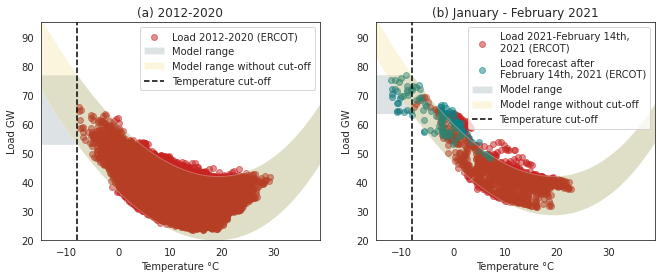

In [24]:
#(fig,(ax1,ax2)) = plt.subplots(2,1,figsize=(6,10))
(fig,(ax1,ax2)) = plt.subplots(1,2,figsize=(11,4))

ax1.scatter(tp_winter.tp['2012':'2020'],load_winter['2012':'2020']/1000,alpha=0.5,label='Load 2012-2020 (ERCOT)')
#ax1.scatter(tpfc_winter.tp['2021-02-15':],loadfc_winter['2021-02-15':]/1000,alpha=0.5,label='Load forecast after\nFebruary 14th, 2021 (ERCOT)')

ax1.fill_between(t,ys2_min, ys2_max, where=ys2_min <= ys2_max,
                 facecolor=COLORS[4], interpolate=True,alpha=0.15,label='Model range')
ax1.fill_between(t,ys_min, ys_max, where=ys_min <= ys_max,
                 facecolor=COLORS[2], interpolate=True,alpha=0.15,label='Model range without cut-off')

ax1.set_xlabel('Temperature °C')
ax1.set_ylabel('Load GW')
ax1.vlines(-8,20,95,ls='--',color='Black',label='Temperature cut-off')
ax1.set_ylim((20,95))
ax1.set_xlim((-15,39))
ax1.legend()
ax1.set_title('(a) 2012-2020')



ax2.scatter(tp_winter.tp['2021':'2021-02-14'],load_winter['2021':'2021-02-14']/1000,alpha=0.5,label='Load 2021-February 14th,\n2021 (ERCOT)')
ax2.scatter(tpfc_winter.tp['2021-02-15':],loadfc_winter['2021-02-15':]/1000,alpha=0.5,label='Load forecast after\nFebruary 14th, 2021 (ERCOT)')

ax2.fill_between(t,ys2_min2021, ys2_max2021, where=ys2_min2021 <= ys2_max2021,
                 facecolor=COLORS[4], interpolate=True,alpha=0.15,label='Model range')
ax2.fill_between(t,ys_min2021, ys_max2021, where=ys_min2021 <= ys_max2021,
                 facecolor=COLORS[2], interpolate=True,alpha=0.15,label='Model range without cut-off')

ax2.set_xlabel('Temperature °C')
ax2.set_ylabel('Load GW')
ax2.vlines(-8,20,95,ls='--',color='Black',label='Temperature cut-off')
ax2.set_ylim((20,95))
ax2.set_xlim((-15,39))
ax2.legend()
ax2.set_title('(b) January - February 2021')

plt.savefig(fig_path + 'model_range_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

#### plot with 2021 "hose"

find minimum and maximum within period

In [256]:
i2021 = tp_winter.tp['2021'].index
xs2021 = makex(i2021,pd.DataFrame({'tp':[-8]},index=i2021),'2004-01-01',ref_time=0)
ys2021 = ((xs2021*coef).sum(axis=1)+inte)/1000

In [257]:
max_time2021 = tp_winter['2021'].index[ys2021==ys2021.max()]
min_time2021 = tp_winter['2021'].index[ys2021==ys2021.min()]

In [280]:
t = np.arange(-15,40)
t2 = t.copy()
t2[t2<-8] = -8

tdf_min2021 = pd.DataFrame({'tp':t},index=np.repeat(min_time2021,len(t)))
tdf_max2021 = pd.DataFrame({'tp':t},index=np.repeat(max_time2021,len(t)))
t2df_min2021 = pd.DataFrame({'tp':t2},index=np.repeat(min_time2021,len(t2)))
t2df_max2021 = pd.DataFrame({'tp':t2},index=np.repeat(max_time2021,len(t2)))
# add some data to get dummies right
tdf_min_extended2021 = pd.concat([tdf_min2021,tp_winter['2012-01']],axis=0)
tdf_max_extended2021 = pd.concat([tdf_max2021,tp_winter['2012-01']],axis=0)
t2df_min_extended2021 = pd.concat([t2df_min2021,tp_winter['2012-01']],axis=0)
t2df_max_extended2021 = pd.concat([t2df_max2021,tp_winter['2012-01']],axis=0)
# calculate x variables
xs_min2021 = makex(tdf_min_extended2021.index,tdf_min_extended2021,'2004-01-01',ref_time=0)[tdf_min_extended2021.index==min_time2021[0],:]
xs_max2021 = makex(tdf_max_extended2021.index,tdf_max_extended2021,'2004-01-01',ref_time=0)[tdf_max_extended2021.index==max_time2021[0],:]
xs2_min2021 = makex(t2df_min_extended2021.index,t2df_min_extended2021,'2004-01-01',ref_time=0)[t2df_min_extended2021.index==min_time2021[0],:]
xs2_max2021 = makex(t2df_max_extended2021.index,t2df_max_extended2021,'2004-01-01',ref_time=0)[t2df_max_extended2021.index==max_time2021[0],:]
# calculate loads
ys_min2021 = ((xs_min2021*coef).sum(axis=1)+inte)/1000
ys_max2021 = ((xs_max2021*coef).sum(axis=1)+inte)/1000
ys2_min2021 = ((xs2_min2021*coef).sum(axis=1)+inte)/1000
ys2_max2021 = ((xs2_max2021*coef).sum(axis=1)+inte)/1000

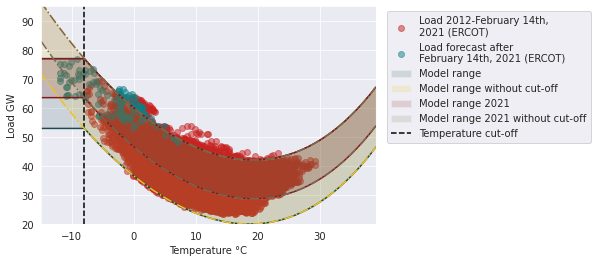

In [282]:
temp_thresh = -8

t = np.arange(-15,40)
tc = t.copy()
tc[tc<temp_thresh] = temp_thresh
# model with fixed time parameters
tr = (pd.to_datetime('2021-01-01') - pd.to_datetime('2004-01-01'))/np.timedelta64(1,'h')
xnt = [1]+[0]*23+[1]+[0]*6+[0]*3+[tr]
x = np.concatenate([(np.array([xnt]*len(tc))),np.array([tc*tr,tc,tc**2,tc**4]).transpose()],axis=1)
l = model.predict(x)

x2 = np.concatenate([(np.array([xnt]*len(t))),np.array([t*tr,t,t**2,t**4]).transpose()],axis=1)
l2 = model.predict(x2)

plt.scatter(tp_winter.tp['2012':'2021-02-14'],load_winter['2012':'2021-02-14']/1000,alpha=0.5,label='Load 2012-February 14th,\n2021 (ERCOT)')
plt.scatter(tpfc_winter.tp['2021-02-15':],loadfc_winter['2021-02-15':]/1000,alpha=0.5,label='Load forecast after\nFebruary 14th, 2021 (ERCOT)')

plt.fill_between(t,ys2_min, ys2_max, where=ys2_min <= ys2_max,
                 facecolor=COLORS[4], interpolate=True,alpha=0.15,label='Model range')
plt.fill_between(t,ys_min, ys_max, where=ys_min <= ys_max,
                 facecolor=COLORS[2], interpolate=True,alpha=0.15,label='Model range without cut-off')
plt.plot(t,ys2_min,color=COLORS[4])
plt.plot(t,ys2_max,color=COLORS[4],label=None)
plt.plot(t,ys_min,color=COLORS[2],ls='-.')
plt.plot(t,ys_max,color=COLORS[2],ls='-.',label=None)

plt.fill_between(t,ys2_min2021, ys2_max2021, where=ys2_min2021 <= ys2_max2021,
                 facecolor=COLORS[5], interpolate=True,alpha=0.15,label='Model range 2021')
plt.fill_between(t,ys_min2021, ys_max2021, where=ys_min2021 <= ys_max2021,
                 facecolor=COLORS[7], interpolate=True,alpha=0.15,label='Model range 2021 without cut-off')
plt.plot(t,ys2_min2021,color=COLORS[5])
plt.plot(t,ys2_max2021,color=COLORS[5],label=None)
plt.plot(t,ys_min2021,color=COLORS[7],ls='-.')
plt.plot(t,ys_max2021,color=COLORS[7],ls='-.',label=None)

plt.xlabel('Temperature °C')
plt.ylabel('Load GW')
plt.vlines(-8,20,95,ls='--',color='Black',label='Temperature cut-off')
plt.ylim((20,95))
plt.xlim((-15,39))
plt.legend(bbox_to_anchor=(1.02,1))
#plt.legend()
#plt.savefig(fig_path + 'model_range_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

In [ ]:
temp_thresh = -8

t = np.arange(-15,40)
tc = t.copy()
tc[tc<temp_thresh] = temp_thresh
# model with fixed time parameters
tr = (pd.to_datetime('2021-01-01') - pd.to_datetime('2004-01-01'))/np.timedelta64(1,'h')
xnt = [1]+[0]*23+[1]+[0]*6+[0]*3+[tr]
x = np.concatenate([(np.array([xnt]*len(tc))),np.array([tc*tr,tc,tc**2,tc**4]).transpose()],axis=1)
l = model.predict(x)

x2 = np.concatenate([(np.array([xnt]*len(t))),np.array([t*tr,t,t**2,t**4]).transpose()],axis=1)
l2 = model.predict(x2)

plt.scatter(tp_winter.tp['2021':'2021-02-14'],load_winter['2021':'2021-02-14']/1000,alpha=0.5,label='Load 2021-February 14th,\n2021 (ERCOT)')
plt.scatter(tpfc_winter.tp['2021-02-15':],loadfc_winter['2021-02-15':]/1000,alpha=0.5,label='Load forecast after\nFebruary 14th, 2021 (ERCOT)')

#plt.fill_between(t,ys2_min, ys2_max, where=ys2_min <= ys2_max,
#                 facecolor=COLORS[4], interpolate=True,alpha=0.15,label='Model range')
#plt.fill_between(t,ys_min, ys_max, where=ys_min <= ys_max,
#                 facecolor=COLORS[2], interpolate=True,alpha=0.15,label='Model range without cut-off')
#plt.plot(t,ys2_min,color=COLORS[4])
#plt.plot(t,ys2_max,color=COLORS[4],label=None)
#plt.plot(t,ys_min,color=COLORS[2],ls='-.')
#plt.plot(t,ys_max,color=COLORS[2],ls='-.',label=None)

plt.fill_between(t,ys2_min2021, ys2_max2021, where=ys2_min2021 <= ys2_max2021,
                 facecolor=COLORS[5], interpolate=True,alpha=0.15,label='Model range 2021')
plt.fill_between(t,ys_min2021, ys_max2021, where=ys_min2021 <= ys_max2021,
                 facecolor=COLORS[7], interpolate=True,alpha=0.15,label='Model range 2021 without cut-off')
plt.plot(t,ys2_min2021,color=COLORS[5])
plt.plot(t,ys2_max2021,color=COLORS[5],label=None)
plt.plot(t,ys_min2021,color=COLORS[7],ls='-.')
plt.plot(t,ys_max2021,color=COLORS[7],ls='-.',label=None)

plt.xlabel('Temperature °C')
plt.ylabel('Load GW')
plt.vlines(-8,20,95,ls='--',color='Black',label='Temperature cut-off')
plt.ylim((20,95))
plt.xlim((-15,39))
plt.legend(bbox_to_anchor=(1.02,1))
#plt.legend()
#plt.savefig(fig_path + 'model_range_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

#### plot without "hose"

In [ ]:
temp_thresh = -8

t = np.arange(-15,40)
tc = t.copy()
tc[tc<temp_thresh] = temp_thresh
# model with fixed time parameters
tr = (pd.to_datetime('2021-01-01') - pd.to_datetime('2004-01-01'))/np.timedelta64(1,'h')
xnt = [1]+[0]*23+[1]+[0]*6+[0]*3+[tr]
x = np.concatenate([(np.array([xnt]*len(tc))),np.array([tc*tr,tc,tc**2,tc**4]).transpose()],axis=1)
l = model.predict(x)

x2 = np.concatenate([(np.array([xnt]*len(t))),np.array([t*tr,t,t**2,t**4]).transpose()],axis=1)
l2 = model.predict(x2)

#plt.scatter(tpfc_winter.tp['2012':].temp,ldtp10_winter_1221['2012':]/1000,alpha=0.2,label='load est\n2012-2021')
#plt.scatter(tpfc_winter.tp['2021-02'],loadfc_winter['2021-02']/1000,alpha=0.5,label='load forecast\nFeb2021')
plt.scatter(tp_winter.tp['2012':'2021-02-14'],load_winter['2012':'2021-02-14']/1000,alpha=0.5,label='Load 2012-February 14th,\n2021 (ERCOT)')
plt.scatter(tpfc_winter.tp['2021-02-15':],loadfc_winter['2021-02-15':]/1000,alpha=0.5,label='Load forecast after\nFebruary 14th, 2021 (ERCOT)')
plt.plot(t,l/1000,color=COLORS[4],label='Model fixed time pararameter')
plt.plot(t[:8],l2[:8]/1000,color=COLORS[2],label='Model fixed time pararameter\n without cut-off')
plt.xlabel('Temperature °C')
plt.ylabel('Load GW')
plt.vlines(-8,22,77,ls='--',color='Black',label='Temperature cut-off')
plt.ylim((20,100))
plt.legend()
plt.savefig(fig_path + 'model_range_LR24temptrend_Hook-8.pdf',dpi=300)

## boxplot loads

In [16]:
ldtp70_winter_1220_tt8 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

In [17]:
# estimate load for each year
for year in range(2004,2021):
    ldtp1_winter_1220 = est_load1_year(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01',year) # changed model year to 2012-2020

    if 'ldtp17_winter_1220' in globals():
        ldtp17_winter_1220 = pd.concat([ldtp17_winter_1220,ldtp1_winter_1220],axis=0)
    else:
        ldtp17_winter_1220 = ldtp1_winter_1220

In [18]:
#enddate = '2021-02-14'
enddate = '2021-01'
# act load summer
load_actual_summer = pd.DataFrame({'load':load[(load.index.month>2)&(load.index.month<12)].ld.values/1000,
                                    'dataset':'summer 17y',
                                    'type':'observed'})
# act load winter
load_actual_winter = pd.DataFrame({'load':load[(load.index.month<3)|(load.index.month>11)][:enddate].ld.values/1000,
                                   'dataset':'winter 17y ',
                                   'type':'observed'})
# pred load 2004-2021/01
load_pred_winter17y = pd.DataFrame({'load':ldtp17_winter_1220[:enddate]/1000,
                                    'dataset':'winter 17y',
                                    'type':'predicted'})
# pred load 71 years
load_pred_winter71y = pd.DataFrame({'load':ldtp70_winter_1220_tt8.load_est[:enddate]/1000,
                                    'dataset':'winter 71y',
                                    'type':'predicted'})
load_data_boxplot = pd.concat([load_actual_summer,load_actual_winter,load_pred_winter17y,load_pred_winter71y],axis=0)

In [19]:
load_pred_202102ext = pd.DataFrame({'load':np.tile(ldtp70_winter_1220_tt8['2021-02-15':'2021-02-16'].load_est.values/1000,4),
                                    'dataset':np.repeat(['summer 17y','winter 17y ','winter 17y','winter 71y'],48)})

### new: two panels

plot two panels:

1.

- observed summer loads
- observed winter loads

2. 

- predicted demand with timetrend
- predicted demand with 2021 demand level
- predicted demand for the 2021 event

In [20]:
load_data_boxplot_observed = pd.concat([load_actual_summer,load_actual_winter],axis=0)
load_data_boxplot_predicted = pd.concat([load_pred_winter17y,load_pred_winter71y,
                                        pd.DataFrame({'load':ldtp70_winter_1220_tt8['2021-02-15':'2021-02-16'].load_est.values/1000,
                                                      'dataset':'February 15th\n and 16th 2021'})],axis=0)

In [24]:
load_data_boxplot_observed.to_csv(fig_path_raw + 'FigA1_observed.csv')
load_data_boxplot_predicted.to_csv(fig_path_raw + 'FigA1_predicted.csv')

##### single colour

In [ ]:
(fig,(ax1,ax2)) = plt.subplots(1,2,figsize=(9,4.5),gridspec_kw={'width_ratios': [2,3]})

sns.boxplot(data=load_data_boxplot_observed,x='dataset',y='load',ax=ax1,color=COLORS[0])
ax1.set_title('(a) Observed load')
ax1.set_ylabel('Load GW')
ax1.set_xlabel('')
ax1.set_xticklabels(['2004-2020\nsummer','2004-2020\nwinter'])

sns.boxplot(data=load_data_boxplot_predicted,x='dataset',y='load',ax=ax2,color=COLORS[0])
ax2.set_title('(b) Predicted demand')
ax2.set_ylabel('Demand GW')
ax2.set_xlabel('')
ax2.set_xticklabels(['2004-2020\nwinter','1950-2020\nwinter with\n2021 demand level','February 15th\nand 16th 2021'])

medians1 = load_data_boxplot_observed.groupby(['dataset'])['load'].median()[load_data_boxplot_observed.dataset.unique()]
nobs1 = load_data_boxplot_observed.groupby('dataset').load.count()[load_data_boxplot_observed.dataset.unique()]
medians2 = load_data_boxplot_predicted.groupby(['dataset'])['load'].median()[load_data_boxplot_predicted.dataset.unique()]
nobs2 = load_data_boxplot_predicted.groupby('dataset').load.count()[load_data_boxplot_predicted.dataset.unique()]
 
# Add it to the plot
pos1 = range(len(nobs1))
pos2 = range(len(nobs2))
for tick,label in zip(pos1,ax1.get_xticklabels()):
    ax1.text(pos1[tick],
            medians1[tick] + 0.5,
            'n='+str(nobs1[tick]),
            horizontalalignment='center',
            size='small',
            color='white',
            weight='semibold')
for tick,label in zip(pos2,ax2.get_xticklabels()):
    ax2.text(pos2[tick],
            medians2[tick] + 0.5,
            'n='+str(nobs2[tick]),
            horizontalalignment='center',
            size='small',
            color='white',
            weight='semibold')
plt.savefig(fig_path + 'load_pred_obs_vs_feb2021_LR24temptrend_Hook-8.pdf',dpi=300,
           #bbox_extra_artists=(lgd,), bbox_inches='tight')
            bbox_inches='tight')

##### multicolor

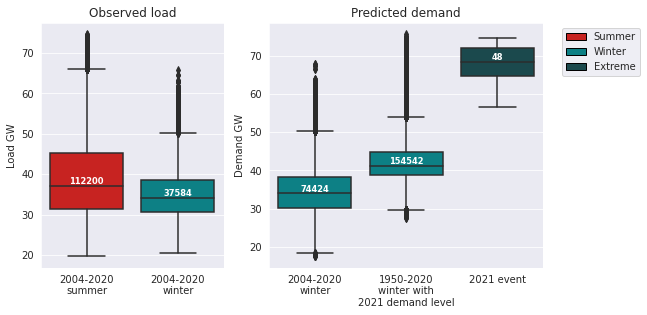

In [114]:
(fig,(ax1,ax2)) = plt.subplots(1,2,figsize=(9,4.5),gridspec_kw={'width_ratios': [2,3]})

sns.boxplot(data=load_data_boxplot_observed,x='dataset',y='load',ax=ax1)
ax1.set_title('Observed load')
ax1.set_ylabel('Load GW')
ax1.set_xlabel('')
ax1.set_xticklabels(['2004-2020\nsummer','2004-2020\nwinter'])
ax1.artists[0].set_facecolor(COLORS[0])
ax1.artists[1].set_facecolor(COLORS[1])

sns.boxplot(data=load_data_boxplot_predicted,x='dataset',y='load',ax=ax2)
ax2.set_title('Predicted demand')
ax2.set_ylabel('Demand GW')
ax2.set_xlabel('')
ax2.set_xticklabels(['2004-2020\nwinter','1950-2020\nwinter with\n2021 demand level','2021 event'])
ax2.artists[0].set_facecolor(COLORS[1])
ax2.artists[1].set_facecolor(COLORS[1])
ax2.artists[2].set_facecolor(COLORS[4])

legend_elements = [Patch(facecolor=COLORS[0], edgecolor='black',
                         label='Summer'),
                   Patch(facecolor=COLORS[1], edgecolor='black',
                         label='Winter'),
                   Patch(facecolor=COLORS[4], edgecolor='black',
                         label='Extreme')]
lgd = ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

medians1 = load_data_boxplot_observed.groupby(['dataset'])['load'].median()[load_data_boxplot_observed.dataset.unique()]
nobs1 = load_data_boxplot_observed.groupby('dataset').load.count()[load_data_boxplot_observed.dataset.unique()]
medians2 = load_data_boxplot_predicted.groupby(['dataset'])['load'].median()[load_data_boxplot_predicted.dataset.unique()]
nobs2 = load_data_boxplot_predicted.groupby('dataset').load.count()[load_data_boxplot_predicted.dataset.unique()]
 
# Add it to the plot
pos1 = range(len(nobs1))
pos2 = range(len(nobs2))
for tick,label in zip(pos1,ax1.get_xticklabels()):
    ax1.text(pos1[tick],
            medians1[tick] + 0.5,
            nobs1[tick],
            horizontalalignment='center',
            size='small',
            color='white',
            weight='semibold')
for tick,label in zip(pos2,ax2.get_xticklabels()):
    ax2.text(pos2[tick],
            medians2[tick] + 0.5,
            nobs2[tick],
            horizontalalignment='center',
            size='small',
            color='white',
            weight='semibold')
plt.savefig(fig_path + 'load_pred_obs_vs_feb2021_LR24temptrend_Hook-8.pdf',dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')

# predict 2004-2021

In [105]:
# estimate load for each year
model1220 = est_load_model(loadfc_winter,tpfc_winter,'2012','2020',-8,False,'2004-01-01')
ldtp0420_winter_1220 = est_load_with_model(tpfc_winter['2004':],model,-8,'2004-01-01',0)

In [107]:
load_est17 = pd.concat([load,ldtp0420_winter_1220],axis=1).dropna()
load_est17.columns = ['load','load_est']
load_est17.to_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv')

In [45]:
load_est17 = pd.read_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

In [52]:
print('Correlation & RMSE & R2\\ \hline')
for year in range(2004,2021):
    print_stat_latex(load_est17[str(year)].load_est,load_est17[str(year)].load,year)
print_stat_latex(load_est17['2021-01'].load_est,load_est17['2021-01'].load,'2021-01')

Correlation & RMSE & R2\ \hline
2004 & 0.95 & 3.86 & 0.37 \
2005 & 0.95 & 3.87 & 0.32 \
2006 & 0.93 & 3.27 & 0.41 \
2007 & 0.91 & 3.91 & 0.36 \
2008 & 0.92 & 3.27 & 0.54 \
2009 & 0.94 & 1.99 & 0.83 \
2010 & 0.95 & 1.92 & 0.87 \
2011 & 0.97 & 1.69 & 0.94 \
2012 & 0.95 & 1.46 & 0.9 \
2013 & 0.96 & 1.65 & 0.9 \
2014 & 0.96 & 1.74 & 0.92 \
2015 & 0.95 & 1.89 & 0.87 \
2016 & 0.94 & 1.71 & 0.87 \
2017 & 0.95 & 1.79 & 0.89 \
2018 & 0.96 & 1.88 & 0.9 \
2019 & 0.94 & 1.62 & 0.87 \
2020 & 0.94 & 1.58 & 0.87 \
2021-01 & 0.96 & 1.31 & 0.92 \


# estimate 70 years with model without cut-off

In [157]:
model = est_load_model(loadfc_winter,tpfc_winter,'2012','2020',-20,False,'2004-01-01')
ldtp70_winter_1220_nocut = est_load_with_model(tpfc_winter,model,-20,'2004-01-01',load.index[-1])

# calculate outages

In [25]:
s = pd.to_datetime('2021-02-15 00:00').tz_localize('Etc/GMT+6')
e = pd.to_datetime('2021-02-19 10:30').tz_localize('Etc/GMT+6')
deficit = (ldtp70_winter_1220_tt8long - load.ld)/1000
deficit[deficit>0][s:e].sum()

1449.5681446458393

In [21]:
# load threshold
thresh_total = pd.read_csv(tx_path + 'thresholds/thresh_total63.5GW.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')['0']
thresh_totalPP = pd.read_csv(tx_path + 'thresholds/thresh_totalPP63.5GW.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')['0']

In [145]:
ldtp70_winter_1220_tt8['2021-02'].max()

load_est    74755.656507
temp           22.364882
dtype: float64

In [ ]:
ldt

In [42]:
deficitPP = (ldtp70_winter_1220_tt8.load_est/1000 - thresh_totalPP)
eventsPP = deficitPP[deficitPP>0].resample('M').sum().replace(0,np.nan).dropna()
len(eventsPP)

26

In [151]:
deficitPP['2021-02'][deficitPP['2021-02']>0].sum()

1494.077471700204

In [44]:
(deficitPP['2021-02']>0).sum()

106

In [153]:
deficitPP['2021-02'].max()

31.283762073019027

In [125]:
eventsPP

1950-12-31 00:00:00-06:00       1.273909
1951-01-31 00:00:00-06:00      11.281243
1951-02-28 00:00:00-06:00     944.815659
1959-01-31 00:00:00-06:00       1.757066
1962-01-31 00:00:00-06:00    1245.197432
1963-01-31 00:00:00-06:00     356.239019
1964-01-31 00:00:00-06:00       2.482314
1966-01-31 00:00:00-06:00       1.823041
1970-01-31 00:00:00-06:00       2.660334
1976-01-31 00:00:00-06:00       5.890571
1977-01-31 00:00:00-06:00       1.687416
1978-01-31 00:00:00-06:00       1.196745
1979-01-31 00:00:00-06:00     416.633301
1981-02-28 00:00:00-06:00       1.494955
1982-01-31 00:00:00-06:00     401.975609
1983-12-31 00:00:00-06:00    1245.730226
1984-01-31 00:00:00-06:00       0.478828
1985-01-31 00:00:00-06:00      10.119619
1985-02-28 00:00:00-06:00     352.770427
1989-12-31 00:00:00-06:00    1142.536033
1996-02-29 00:00:00-06:00       0.967448
1996-12-31 00:00:00-06:00       2.675773
2010-01-31 00:00:00-06:00       3.767385
2011-02-28 00:00:00-06:00       0.872124
2018-01-31 00:00

In [126]:
eventsPP.resample('Y').sum().replace(0,np.nan).dropna()

1950-12-31 00:00:00-06:00       1.273909
1951-12-31 00:00:00-06:00     956.096902
1959-12-31 00:00:00-06:00       1.757066
1962-12-31 00:00:00-06:00    1245.197432
1963-12-31 00:00:00-06:00     356.239019
1964-12-31 00:00:00-06:00       2.482314
1966-12-31 00:00:00-06:00       1.823041
1970-12-31 00:00:00-06:00       2.660334
1976-12-31 00:00:00-06:00       5.890571
1977-12-31 00:00:00-06:00       1.687416
1978-12-31 00:00:00-06:00       1.196745
1979-12-31 00:00:00-06:00     416.633301
1981-12-31 00:00:00-06:00       1.494955
1982-12-31 00:00:00-06:00     401.975609
1983-12-31 00:00:00-06:00    1245.730226
1984-12-31 00:00:00-06:00       0.478828
1985-12-31 00:00:00-06:00     362.890046
1989-12-31 00:00:00-06:00    1142.536033
1996-12-31 00:00:00-06:00       3.643221
2010-12-31 00:00:00-06:00       3.767385
2011-12-31 00:00:00-06:00       0.872124
2018-12-31 00:00:00-06:00       9.750115
2021-12-31 00:00:00-06:00    1494.077472
dtype: float64

In [43]:
eventsPP[eventsPP<100].sum()/eventsPP[eventsPP>100].sum()

0.007918300469173254

In [127]:
eventsPP[eventsPP<100].sum()

60.17888701420388

In [128]:
eventsPP[eventsPP>100].min()

352.7704268275183

In [129]:
pd.Series(eventsPP.values,index=eventsPP.index.year)

1950       1.273909
1951      11.281243
1951     944.815659
1959       1.757066
1962    1245.197432
1963     356.239019
1964       2.482314
1966       1.823041
1970       2.660334
1976       5.890571
1977       1.687416
1978       1.196745
1979     416.633301
1981       1.494955
1982     401.975609
1983    1245.730226
1984       0.478828
1985      10.119619
1985     352.770427
1989    1142.536033
1996       0.967448
1996       2.675773
2010       3.767385
2011       0.872124
2018       9.750115
2021    1494.077472
dtype: float64

In [130]:
eventsPP[eventsPP>100]

1951-02-28 00:00:00-06:00     944.815659
1962-01-31 00:00:00-06:00    1245.197432
1963-01-31 00:00:00-06:00     356.239019
1979-01-31 00:00:00-06:00     416.633301
1982-01-31 00:00:00-06:00     401.975609
1983-12-31 00:00:00-06:00    1245.730226
1985-02-28 00:00:00-06:00     352.770427
1989-12-31 00:00:00-06:00    1142.536033
2021-02-28 00:00:00-06:00    1494.077472
dtype: float64

In [131]:
eventsPP[eventsPP<100].sum()

60.17888701420388

In [132]:
eventsPP.sum()

7660.154064577413

### calculate outages for not cut model

In [161]:
deficitPP_nocut = (ldtp70_winter_1220_nocut/1000 - thresh_totalPP)
eventsPP_nocut = deficitPP_nocut[deficitPP_nocut>0].resample('M').sum().replace(0,np.nan).dropna()
len(eventsPP_nocut)

26

In [164]:
(eventsPP_nocut.sum()-eventsPP.sum())/eventsPP.sum()

0.08314051726651316